In [4]:
from Utils.Solver import *
from Utils.Signals import *

In [5]:
# Let's assume we are interested in the following stocks: AAPL, MSFT, TSLA, AMZN, GOOG
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
# Signal scores for AAPL, MSFT, TSLA, AMZN, GOOG
signal_scores = np.array([1.0, 1.5, 0.5, 0.25, 1.75])  # Example signal scores
start_date ='2021-01-15'
end_date ='2022-01-15'

# Step 1: Download historical stock data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


## Signals 

In [6]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


### RSI SIGNAL

In [7]:
# Calculate the RSI signal scores
rsi_signal_scores = calculate_rsi_signal(data, tickers, date='2022-12-23', period=14)
rsi_scores = [score[1] for score in rsi_signal_scores]
rsi_scores_array = np.array(rsi_scores)
print(rsi_scores_array)

[35.69460129 44.14051879 19.81992342 38.02756082 40.44856426]


     pcost       dcost       gap    pres   dres
 0: -1.2478e-01 -1.1479e+00  1e+00  1e-16  3e+00
 1: -1.2557e-01 -1.5230e-01  3e-02  4e-17  7e-02
 2: -1.2688e-01 -1.2801e-01  1e-03  1e-16  1e-03
 3: -1.2692e-01 -1.2694e-01  2e-05  1e-16  1e-05
 4: -1.2692e-01 -1.2692e-01  2e-07  3e-17  1e-07
 5: -1.2692e-01 -1.2692e-01  2e-09  1e-16  1e-09
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.20047975055492864), 'MSFT': np.float64(0.2597472943672142), 'TSLA': np.float64(0.08908238707323841), 'AMZN': np.float64(0.2168508292955642), 'GOOG': np.float64(0.2338397387090546)}
Final Portfolio Weights: [0.20047975 0.25974729 0.08908239 0.21685083 0.23383974]


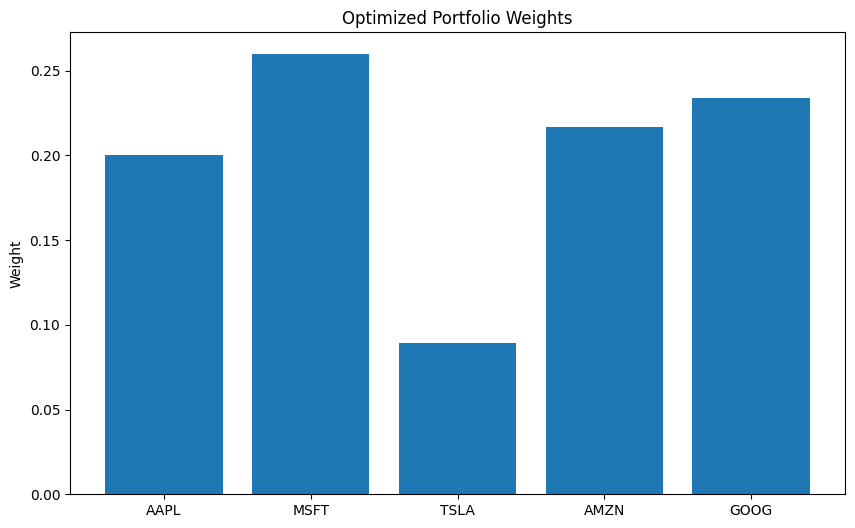

In [8]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
rsi_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, rsi_scores_array)
print("Final Portfolio Weights:", rsi_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

In [ ]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, rsi_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### MACD signal

In [ ]:
# Calculate MACD for a specific date (e.g., '2021-01-15')
macd_signal = calculate_macd_signal(data, tickers, '2021-01-15')
macd_scores = [score[1] for score in macd_signal]
macd_scores_array = np.array(macd_scores)

In [ ]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
macd_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, macd_scores_array)
print("Final Portfolio Weights:", macd_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=macd_portfolio_weights)

In [ ]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, macd_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### SMA signal

In [ ]:
# Calculate SMA crossover signal for a specific date (e.g., '2021-01-15')
sma_signal = calculate_sma_signal(data, tickers, '2021-01-15')
sma_scores = [score[1] for score in sma_signal]
sma_scores_array = np.array(sma_scores)
print(sma_scores_array)

In [ ]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
sma_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, sma_scores_array)
print("Final Portfolio Weights:", sma_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=sma_portfolio_weights)

In [ ]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

In [ ]:

trading_dates = ['2021-01-15']
# Example of Iterative Optimization
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    


# Prepare data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2021-01-04'
end_date = '2021-01-05'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = [1, 1, 1]  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    combined_scores_with_tickers = list(zip(tickers, combined_scores))

    print(f"Combined Scores", combined_scores_with_tickers)

[*********************100%***********************]  5 of 5 completed

processing 2021-01-04 00:00:00
SIGNAL SCORES [['AAPL', np.float64(20.081623973846433)], ['MSFT', np.float64(14.962100067138692)], ['TSLA', np.float64(67.97656603813171)], ['AMZN', np.float64(14.464915924072272)], ['GOOG', np.float64(11.452275848388666)]]
RSI : [['AAPL', np.float64(54.95765260611664)], ['MSFT', np.float64(48.908071644387164)], ['TSLA', np.float64(71.86002956306031)], ['AMZN', np.float64(48.36221551762188)], ['GOOG', np.float64(45.159792296518226)]]
MACD : [['AAPL', np.float64(0.03976389153491855)], ['MSFT', np.float64(-0.033559229510428334)], ['TSLA', np.float64(0.42445878093217004)], ['AMZN', np.float64(0.19824201898529015)], ['GOOG', np.float64(-0.2823899360974559)]]
SMA : [20.08162397 14.96210007 67.97656604 14.46491592 11.45227585]
Combined Scores [ 75.07904047  63.83661248 140.26105438  63.02537346  56.32967821]
processing 2021-01-05 00:00:00
SIGNAL SCORES [['AAPL', np.float64(20.021950473785395)], ['MSFT', np.float64(14.637319183349632)], ['TSLA', np.float64(68.95

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2021-01-04'
end_date = '2021-01-05'
date_range = pd.date_range(start=start_date, end=end_date)


# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")
    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    print("rsi_BEFORE", rsi_signal_scores)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    print("MACD_BEFORE", macd_signal_scores)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    print("sma_scores_BEFORE", sma_signal_scores)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")


display(data)

[*********************100%***********************]  5 of 5 completed

processing 2021-01-04 00:00:00
rsi_BEFORE [['AAPL', np.float64(54.95765260611664)], ['MSFT', np.float64(48.908071644387164)], ['TSLA', np.float64(71.86002956306031)], ['AMZN', np.float64(48.36221551762188)], ['GOOG', np.float64(45.159792296518226)]]
MACD_BEFORE [['AAPL', np.float64(0.03976389153491855)], ['MSFT', np.float64(-0.033559229510428334)], ['TSLA', np.float64(0.42445878093217004)], ['AMZN', np.float64(0.19824201898529015)], ['GOOG', np.float64(-0.2823899360974559)]]
SIGNAL SCORES [['AAPL', np.float64(20.081623973846433)], ['MSFT', np.float64(14.962100067138692)], ['TSLA', np.float64(67.97656603813171)], ['AMZN', np.float64(14.464915924072272)], ['GOOG', np.float64(11.452275848388666)]]
sma_scores_BEFORE [['AAPL', np.float64(20.081623973846433)], ['MSFT', np.float64(14.962100067138692)], ['TSLA', np.float64(67.97656603813171)], ['AMZN', np.float64(14.464915924072272)], ['GOOG', np.float64(11.452275848388666)]]
RSI : [['AAPL', np.float64(54.95765260611664)], ['MSFT', np.float64(

Price            Close                                                \
Ticker            AAPL       AMZN       GOOG        MSFT        TSLA   
Date                                                                   
2020-01-02   72.716072  94.900497  68.046204  153.323273   28.684000   
2020-01-03   72.009132  93.748497  67.712273  151.414062   29.534000   
2020-01-06   72.582909  95.143997  69.381882  151.805481   30.102667   
2020-01-07   72.241554  95.343002  69.338577  150.421341   31.270666   
2020-01-08   73.403648  94.598503  69.885002  152.817352   32.809334   
...                ...        ...        ...         ...         ...   
2022-12-23  130.344467  85.250000  89.386620  234.405396  123.150002   
2022-12-27  128.535507  83.040001  87.515488  232.667496  109.099998   
2022-12-28  124.591385  81.820000  86.052414  230.281509  112.709999   
2022-12-29  128.120346  84.180000  88.530678  236.644119  121.820000   
2022-12-30  128.436661  84.000000  88.311714  235.475708  123.180000   

Price             High                                                ...  \
Ticker            AAPL       AMZN       GOOG        MSFT        TSLA  ...   
Date                                                                  ...   
2020-01-02   72.776598  94.900497  68.084520  153.428276   28.713333  ...   
2020-01-03   72.771760  94.309998  68.301485  152.683644   30.266666  ...   
2020-01-06   72.621646  95.184502  69.495836  151.872308   30.104000  ...   
2020-01-07   72.849231  95.694504  69.818801  152.416391   31.441999  ...   
2020-01-08   73.706279  95.550003  70.246290  153.495104   33.232666  ...   
...                ...        ...        ...         ...         ...  ...   
2022-12-23  130.898028  85.779999  89.675253  234.542859  128.619995  ...   
2022-12-27  129.899651  85.349998  89.078086  234.601796  119.669998  ...   
2022-12-28  129.524031  83.480003  88.102700  235.377495  116.269997  ...   
2022-12-29  128.980342  84.550003  88.943722  237.537638  123.570000  ...   
2022-12-30  128.456435  84.050003  88.411241  235.613171  124.480003  ...   

Price             Open                                                \
Ticker            AAPL       AMZN       GOOG        MSFT        TSLA   
Date                                                                   
2020-01-02   71.721019  93.750000  66.761289  151.566865   28.299999   
2020-01-03   71.941343  93.224998  67.075290  151.127703   29.366667   
2020-01-06   71.127866  93.000000  67.181800  149.944070   29.364668   
2020-01-07   72.592601  95.224998  69.567496  152.082300   30.760000   
2020-01-08   71.943759  94.902000  69.275880  151.710046   31.580000   
...                ...        ...        ...         ...         ...   
2022-12-23  129.415269  83.250000  87.206949  231.832862  126.370003   
2022-12-27  129.869997  84.970001  88.888979  234.375966  117.500000   
2022-12-28  128.179661  82.800003  87.087512  232.598759  110.349998   
2022-12-29  126.518963  82.870003  86.619731  231.381215  120.389999   
2022-12-30  126.934142  83.120003  86.953144  233.894872  119.949997   

Price          Volume                                           
Ticker           AAPL      AMZN      GOOG      MSFT       TSLA  
Date                                                            
2020-01-02  135480400  80580000  28132000  22622100  142981500  
2020-01-03  146322800  75288000  23728000  21116200  266677500  
2020-01-06  118387200  81236000  34646000  20813700  151995000  
2020-01-07  108872000  80898000  30054000  21634100  268231500  
2020-01-08  132079200  70160000  30560000  27746500  467164500  
...               ...       ...       ...       ...        ...  
2022-12-23   63814900  57433700  17815000  21207000  166989700  
2022-12-27   69007800  57284000  15470900  16688600  208643400  
2022-12-28   85438400  58228600  17879600  17457100  221070500  
2022-12-29   75703700  54995900  18280700  19770700  221923300  
2022-12-30   77034200  62401200  19190300  21938500  15777

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2021-01-01'
end_date = '2022-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = [1, 1, 1]  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    print(f"Combined Scores", combined_scores)

    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)

# You can now use this DataFrame for training your model.
display(df)

[*********************100%***********************]  5 of 5 completed


processing 2021-01-01 00:00:00
Skipping 2021-01-01 00:00:00 due to NaN values in the signals.
processing 2021-01-02 00:00:00
Skipping 2021-01-02 00:00:00 due to NaN values in the signals.
processing 2021-01-03 00:00:00
Skipping 2021-01-03 00:00:00 due to NaN values in the signals.
processing 2021-01-04 00:00:00
RSI : [['AAPL', np.float64(54.95761190983279)], ['MSFT', np.float64(48.90809406771597)], ['TSLA', np.float64(71.86002956306031)], ['AMZN', np.float64(48.36221551762188)], ['GOOG', np.float64(45.15979998146727)]]
MACD : [['AAPL', np.float64(0.03976272688261151)], ['MSFT', np.float64(-0.03355862401629395)], ['TSLA', np.float64(0.42445878093217004)], ['AMZN', np.float64(0.19824201898529015)], ['GOOG', np.float64(-0.2823904461455494)]]
SMA : [20.08162767 14.96210022 67.97656604 14.46491592 11.45227465]
Combined Scores [ 75.07900231  63.83663566 140.26105438  63.02537346  56.32968418]
     pcost       dcost       gap    pres   dres
 0: -1.3296e-01 -1.2081e+00  1e+00  2e-16  3e+00
 1:

,date,rsi_scores,macd_scores,sma_scores,combined_scores,portfolio_weights,total_return,annualized_return
0,2021-01-04,"[54.95761190983279, 48.90809406771597, 71.8600...","[0.03976272688261151, -0.03355862401629395, 0....","[20.08162767410279, 14.962100219726551, 67.976...","[75.0790023108182, 63.83663566342623, 140.2610...","[0.18548626093932252, 0.15022443545679742, 0.3...",0.128082,1.752078
1,2021-01-05,"[57.72289570572112, 49.2944479718196, 72.47505...","[-0.14631754917407047, -0.3087954441950047, 0....","[20.021953907012943, 14.63732040405273, 68.956...","[77.59853206355999, 63.622972931677324, 142.24...","[0.18736814378013272, 0.1446179504739881, 0.38...",0.119915,1.589127
2,2021-01-06,"[48.82538045334607, 40.4352098353842, 74.79375...","[-0.560317101404086, -0.8311073659928117, 1.33...","[19.905603332519533, 14.19843963623046, 70.076...","[68.17066668446151, 53.802542105621846, 146.20...","[0.17201368792521968, 0.12522054409413044, 0.4...",0.133032,1.855183
3,2021-01-07,"[55.98302785639675, 50.64661327204687, 80.0120...","[-0.5500006753008888, -0.7593185695102229, 2.7...","[19.87966646194458, 14.024459915161145, 71.523...","[75.31269364304045, 63.911754617697795, 154.26...","[0.1730301842715491, 0.13926757242730173, 0.40...",0.080958,0.923068
4,2021-01-08,"[57.651583588680076, 52.57460778498167, 83.848...","[-0.4718682820445643, -0.6071590192701097, 4.6...","[19.83840841293336, 13.801928329467785, 73.271...","[77.01812371956888, 65.76937709517935, 161.800...","[0.1696166169350463, 0.13754090211726852, 0.41...",0.026499,0.245696
...,...,...,...,...,...,...,...,...
247,2021-12-27,"[66.90672957972423, 59.340808600572316, 58.354...","[-0.1265038232636284, 0.290171860481077, 2.521...","[16.691500778198247, 43.19118621826169, 89.706...","[83.47172653465884, 102.82216667931507, 150.58...","[0.17885918804389003, 0.2319133931523031, 0.36...",-0.076719,-0.488547
248,2021-12-28,"[64.96697144886674, 58.19981296165485, 57.6581...","[-0.06132419805279277, 0.7186072413060369, 3.9...","[17.098228454589844, 43.39803123474121, 90.708...","[82.0038757054038, 102.3164514377021, 152.2803...","[0.17607415668206888, 0.2320733201669392, 0.36...",-0.060340,-0.407136
249,2021-12-29,"[65.06136280064617, 58.698690784926754, 57.351...","[-0.058010596901469924, 0.9836027171525685, 4....","[17.480447921752926, 43.56929542541502, 91.466...","[82.48380012549762, 103.25158892749434, 153.39...","[0.17746764012622107, 0.23473949251096127, 0.3...",-0.048308,-0.340266
250,2021-12-30,"[62.67656022392815, 55.994641941646385, 55.152...","[-0.1731701337893483, 0.9232942402938114, 4.44...","[17.79793304443359, 43.680690078735324, 92.226...","[80.30132313457239, 100.59862626067553, 151.82...","[0.1759517901209588, 0.23306432462568522, 0.37...",-0.062946,-0.420805


In [9]:
import numpy as np
import pandas as pd

# Assuming your existing df is already loaded
# Extract features (signal scores) from the existing DataFrame
# We assume that each column (e.g., rsi_scores) is a list of multiple values.
# We'll extract the first value of each list for the model.

# Extract first values from the lists in each row
X = np.array([[
    row['rsi_scores'][0],  # Assuming each column contains a list, we use the first element
    row['macd_scores'][0],  # Adjust this depending on what score you want to use from each list
    row['sma_scores'][0]    # Same for SMA
] for _, row in df.iterrows()])

# Ensure the shape of X is correct (it should be 2D with each row representing a data point)
print("Shape of X:", X.shape)

# Target (returns), you can choose 'total_return' or 'annualized_return' based on your preference
y = df['total_return'].values.reshape(-1, 1)

# Initialize and train a linear model to learn the weight matrix W
# Using np.linalg.lstsq to solve the least squares problem, i.e., Y = XW
W, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Output the learned weight matrix W
print("Learned Weight Matrix (W):", W)

Shape of X: (252, 3)
Learned Weight Matrix (W): [[ 0.00090616]
 [-0.05405246]
 [-0.00188633]]


# RENDU ICI 

In [ ]:
# Let's test the model with some input signals (for example, RSI=0.4, MACD=0.5, SMA=1.8)
test_data = np.array([[0.4, 0.5, 1.8]])

# Ensure test_data has the same shape as the learned weight matrix
print("Shape of test_data:", test_data.shape)

weighted_values = test_data[0] * W.flatten()
print("Weighted values : ", weighted_values)
# Predicted return (make sure the shapes are aligned)

#TODO: Solve Portfolio
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, weighted_values)
print("Final Portfolio Weights:", portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

#TODO: Display



print("Predicted Return for input [RSI=0.4, MACD=0.5, SMA=1.8]:", )

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2022-01-01'
end_date = '2022-05-05'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
res_dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)

    signal_weights = W  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])


    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    res_dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
res_data = pd.DataFrame(res_dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)


# You can now use this DataFrame for training your model.
display(res_data)

In [ ]:
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    

In [ ]:
%pip install sklearn

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SignalWeightModel(tf.keras.Model):
    def __init__(self):
        super(SignalWeightModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(3, activation='softmax')  # Three outputs: RSI, MACD, SMA weights

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize the model
signal_weight_model = SignalWeightModel()
signal_weight_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [ ]:
class PortfolioOptimizerRL:
    def __init__(self, model):
        self.model = model
        self.discount_factor = 0.99  # Discount factor for future rewards

    def train(self, tickers, data, signals, portfolio_solver, num_epochs=100):
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            for date in data.index:
                # Step 1: Prepare the current state (signal scores for each stock)
                rsi_signal_scores = calculate_rsi_signal(data, tickers, date)
                rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])

                macd_signal_scores = calculate_macd_signal(data, tickers, date)
                macd_scores_array = np.array([score[1] for score in macd_signal_scores])

                sma_signal_scores = calculate_sma_signal(data, tickers, date)
                sma_scores_array = np.array([score[1] for score in sma_signal_scores])

                state = np.array([rsi_scores_array, macd_scores_array, sma_scores_array]).flatten()

                # Step 2: Predict the weights for each signal using the model
                predicted_weights = self.model(state.reshape(1, -1))

                # Step 3: Combine signals with the predicted weights
                combined_scores = combine_signals(predicted_weights[0].numpy(), [rsi_scores_array, macd_scores_array, sma_scores_array])
            
                # Check for NaN values in combined_scores
                if np.any(np.isnan(combined_scores)) or np.any(np.isinf(combined_scores)):
                    continue  # Skip this iteration if there are invalid values

                print(f"Optimized Portfolio Weights:\n{dict(zip(tickers, combined_scores))}")

                # Step 4: Use the portfolio solver to get the portfolio weights based on the combined scores
                portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

                # Step 5: Calculate the portfolio return (reward)
                cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
                reward = annualized_return  # or another performance metric

                # Step 6: Update the model based on the reward
                with tf.GradientTape() as tape:
                    # Forward pass
                    predicted_weights = self.model(state.reshape(1, -1))

                    # Calculate the loss (negative of the reward to minimize loss)
                    loss = -reward

                # Backpropagation
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                print(f"Date: {date}, Reward: {reward}, Loss: {loss}")

In [ ]:
# Initialize the portfolio solver
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Initialize the reinforcement learning optimizer
rl_optimizer = PortfolioOptimizerRL(signal_weight_model)

# Train the model
rl_optimizer.train(tickers, data, signals=None, portfolio_solver=portfolio_solver, num_epochs=100)
